<div style="background-color: #6EC1E4; color: white; padding: 20px; text-align: center; border-radius: 10px;">
    <div style="font-size: 36px; margin-bottom: 10px; font-weight: bold;">Predict Heart Failure During ICU Stay</div>
    <h1 style="font-size: 28px; margin-top: 5px;">Machine Learning in Medicine - MIMIC III Data</h1>
</div>


<h1>Part 1 - EDA</h1>


<h1>Importing Necessary Libraries</h1>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import chisquare
import scipy.stats as stats

<h1>Read the CSV Files</h1>
<p>These CSV files are sourced from <a href="https://physionet.org/content/mimiciii-demo/1.4/" target="_blank">MIMIC-III Demo Dataset</a>.</p>


<h1>Data Preparation and Merging</h1>
<p>This section involves reading CSV files, filtering data, and merging tables:</p>
<ul>
    <li>Read data from multiple CSV files.</li>
    <li>Filter the data using specified <code>itemids</code>.</li>
    <li>Merge the <code>LABEVENTS</code> and <code>D_LABITEMS</code> tables.</li>
    <li>Convert relevant columns to datetime format.</li>
    <li>Match and assign <code>hadm_id</code> and <code>icustay_id</code> to each row.</li>
    <li>Retain only rows with non-null <code>icustay_id</code> and select relevant columns.</li>
</ul>

<p><strong>This process may take some time, approximately 2 minutes.</strong></p>


We merge and join various tables from the MIMIC-III dataset to create a comprehensive DataFrame for analysis. This process involves combining the labevents and d_labitems tables with the admissions and icustays tables. The goal is to merge the itemid that occurred during icustay_id into the resulting table. Next, we merge the chartevents table with the d_items table. Finally, we union these two tables together to create a combined table called the measurements dataset, which contains relevant measurements and observations for cardiac patients.

In [2]:
# Read the CSV files
diagnoses_icd = pd.read_csv('DIAGNOSES_ICD.csv')
icd_diagnoses = pd.read_csv('D_ICD_DIAGNOSES.csv')
patients = pd.read_csv('PATIENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
icu_stays = pd.read_csv('ICUSTAYS.csv')
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)
chartevent_details = pd.read_csv('D_ITEMS.csv')
labevents = pd.read_csv('LABEVENTS.csv')
labitem_details = pd.read_csv('D_LABITEMS.csv')

# Define the itemids to filter
itemids_filter = [
    220045, 227457, 50893, 51265, 43372, 50983, 51301, 227073, 51244, 51006, 50813, 3693,
    226730, 51250, 51248, 51279, 50971, 220210, 220277, 220052, 220050, 220051, 223761,
    224862, 226512, 50882, 50931, 50868, 51265, 51222, 50960, 51301, 51249, 51277, 51250,
    51279, 51248, 50893, 50970, 51037, 646, 5820, 6719, 8554, 226253, 43372, 43576, 50912,
    51146, 50820, 51491, 51237, 781, 3737

]

# Merge LABEVENTS and D_LABITEMS on 'itemid' using a left join
labtotal = pd.merge(labevents, labitem_details, on='itemid', how='left')

# Filter for specific itemids
labtotal = labtotal[labtotal['itemid'].isin(itemids_filter)]

# Convert charttime, admittime, dischtime, intime, outtime to datetime format
labtotal['charttime'] = pd.to_datetime(labtotal['charttime'])
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
icu_stays['intime'] = pd.to_datetime(icu_stays['intime'])
icu_stays['outtime'] = pd.to_datetime(icu_stays['outtime'])

# Function to find hadm_id and icustay_id for each row in labtotal
def find_ids(row):
    subject_id = row['subject_id']
    charttime = row['charttime']
    
    # Find matching admission
    admission = admissions[(admissions['subject_id'] == subject_id) & 
                           (admissions['admittime'] <= charttime) & 
                           (admissions['dischtime'] >= charttime)]
    if not admission.empty:
        row['hadm_id'] = admission.iloc[0]['hadm_id']
    
    # Find matching ICU stay
    icu_stay = icu_stays[(icu_stays['subject_id'] == subject_id) & 
                         (icu_stays['intime'] <= charttime) & 
                         (icu_stays['outtime'] >= charttime)]
    if not icu_stay.empty:
        row['icustay_id'] = icu_stay.iloc[0]['icustay_id']
    
    return row

# Apply the function to each row
labtotal = labtotal.apply(find_ids, axis=1)

# Keep only rows with non-null icustay_id
labtotal = labtotal[labtotal['icustay_id'].notnull()]

# Select and reorder the desired columns
labtotal = labtotal[['subject_id', 'hadm_id', 'icustay_id', 'itemid', 'label', 'charttime', 'value', 'valuenum', 'valueuom']]

labtotal.head()

,subject_id,hadm_id,icustay_id,itemid,label,charttime,value,valuenum,valueuom
699,10006,142345.0,206504.0,50868,Anion Gap,2164-10-24 03:00:00,12,12.0,mEq/L
700,10006,142345.0,206504.0,50882,Bicarbonate,2164-10-24 03:00:00,31,31.0,mEq/L
701,10006,142345.0,206504.0,50893,"Calcium, Total",2164-10-24 03:00:00,8.5,8.5,mg/dL
703,10006,142345.0,206504.0,50912,Creatinine,2164-10-24 03:00:00,3.5,3.5,mg/dL
704,10006,142345.0,206504.0,50931,Glucose,2164-10-24 03:00:00,84,84.0,mg/dL


In [3]:

# Define the itemids to filter
itemids_filter = [
   220045, 227457, 50893, 51265, 43372, 50983, 51301, 227073, 51244, 51006, 50813, 3693,
    226730, 51250, 51248, 51279, 50971, 220210, 220277, 220052, 220050, 220051, 223761,
    224862, 226512, 50882, 50931, 50868, 51265, 51222, 50960, 51301, 51249, 51277, 51250,
    51279, 51248, 50893, 50970, 51037, 646, 5820, 6719, 8554, 226253, 43372, 43576, 50912,
    51146, 50820, 51491, 51237, 781, 3737
]

# Merge CHARTEVENTS and D_ITEMS on 'itemid' using a left join
charttotal = pd.merge(chartevents, chartevent_details, on='itemid', how='left')

# Filter for specific itemids
charttotal = charttotal[charttotal['itemid'].isin(itemids_filter)]

# Convert charttime to datetime format
charttotal['charttime'] = pd.to_datetime(charttotal['charttime'])

# Keep only rows with non-null icustay_id
charttotal = charttotal[charttotal['icustay_id'].notnull()]

# Select and reorder the desired columns
charttotal = charttotal[['subject_id', 'hadm_id', 'icustay_id', 'itemid', 'label', 'charttime', 'value', 'valuenum', 'valueuom']]

# Display the resulting dataframe

# Print the first few rows of the updated dataframe
charttotal.head()

measurments = pd.concat([charttotal, labtotal], ignore_index=True)
measurments.to_csv('measurments.csv')

In [4]:
# Read the CSV files
measurments = pd.read_csv('measurments.csv')

<h1>Defining the Target Population</h1>
<p>To focus on heart disease patients, we use specific <strong>ICD-9 codes</strong> for diagnosis, sourced from relevant medical documentation. The ICD-9 codes related to heart diseases are obtained from <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9956019/" target="_blank">this link</a>.</p>
<p>Additionally, we identify relevant tests (item IDs) based on <a href="https://bmjopen.bmj.com/content/11/7/e044779" target="_blank">this article</a> to capture necessary measurements and observations for cardiac patients.</p>



In [5]:

# Define the target population criteria
# List of ICD-9 codes related to heart diseases - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9956019/

icd9_codes_heart_disease = [
    "39891", "40201", "40211", "40291", "40401", "40403", "40411", "40413", "40491", "40493", "4280", "4281", "42820", 
    "42821", "42822", "42823", "42830", "42831", "42832", "42833", "42840", "42841", "42842", "42843", "4289"
    "42731",  # Atrial fibrillation
    "4241",   # Aortic valve disorders
    "4240",   # Mitral valve disorders
    "41401",  # Coronary atherosclerosis of native coronary artery
    "41071",  # Subendocardial infarction, initial episode of care
    "4019",   # Hypertension, unspecified
    "4266",   # Other heart block
    "43310",  # Occlusion and stenosis of carotid artery without cerebral infarction
    "4271",   # Paroxysmal ventricular tachycardia
    "4160",   # Primary pulmonary hypertension
    "41072",  # Subendocardial infarction, subsequent episode of care
    "41400",  # Coronary atherosclerosis of unspecified type of vessel, native or graft
    "42732",  # Atrial flutter
    "4270"  # Paroxysmal supraventricular tachycardia
]




<h1>Filtering Population and Performing Feature Engineering</h1>
<p>We filter the population based on heart disease ICD-9 codes and perform feature engineering. This includes processing patient data, defining age groups, and merging relevant tables to create a comprehensive dataset for analysis.</p>


In [6]:
# Filter the population and perform feature engineering
# Filter diagnoses data based on the list of ICD-9 codes for heart diseases
merged_diagnoses = pd.merge(diagnoses_icd, icd_diagnoses, on='icd9_code', how='left')
columns_to_drop = ['row_id_x', 'row_id_y', 'long_title', 'seq_num']
merged_diagnoses = merged_diagnoses.drop(columns=columns_to_drop)
filtered_diagnoses = merged_diagnoses[merged_diagnoses['icd9_code'].isin(icd9_codes_heart_disease)]

# Process patient data
patients = patients[['subject_id', 'gender', 'dob', 'dod']]
patients['dob'] = pd.to_datetime(patients['dob'])
patients['dod'] = pd.to_datetime(patients['dod'])
patients['age'] = patients['dod'].dt.year - patients['dob'].dt.year

# Define age ranges for groups in increments of 10 years
bins = list(range(0, 101, 10)) + [float('inf')]
labels = [f'{i}-{i+9}' for i in range(0, 100, 10)] + ['>100']

# Assign each patient to an age group
patients['age_group'] = pd.cut(patients['age'], bins=bins, labels=labels, right=False)
patients = patients[['subject_id', 'gender', 'age', 'age_group']]

# Merge admissions and ICU stays data
merged_admissions = pd.merge(admissions, icu_stays, on=['subject_id', 'hadm_id'], how='left')
admissions_columns_to_drop = ['row_id_x', 'row_id_y', 'language', 'edregtime', 'edouttime', 'marital_status']
merged_admissions = merged_admissions.drop(columns=admissions_columns_to_drop)

#  Merge the filtered dataframes sequentially
merged_data_1 = pd.merge(filtered_diagnoses, patients, on='subject_id', how='left')
merged_data_2 = pd.merge(merged_data_1, merged_admissions, on=['subject_id', 'hadm_id'], how='left')

# Convert deathtime to datetime format
merged_data_2['deathtime'] = pd.to_datetime(merged_data_2['deathtime'])

data = pd.merge(merged_data_2, measurments, on=['subject_id', 'hadm_id', 'icustay_id'], how='left')



In [7]:
data.shape

(83349, 35)

In [8]:
data.columns

Index(['subject_id', 'hadm_id', 'icd9_code', 'short_title', 'gender', 'age',
       'age_group', 'admittime', 'dischtime', 'deathtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'religion',
       'ethnicity', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'icustay_id', 'dbsource', 'first_careunit',
       'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime',
       'los', 'Unnamed: 0', 'itemid', 'label', 'charttime', 'value',
       'valuenum', 'valueuom'],
      dtype='object')

<h1>Linking Lab Tests to ICU Stays</h1>
<p>Linking lab tests to ICU stays if conducted within 24 hours before admission or during the stay. Converting time columns to datetime format for accurate filtering. Adding a 'died' column to indicate if the patient died during the ICU stay and calculating the duration of hospital and ICU stays in days.</p>


<h1>Data Transformation and Aggregation</h1>
<p>This section converts relevant columns to datetime format, filters the data, and performs calculations:</p>
<ul>
    <li>Convert <code>charttime</code>, <code>admittime</code>, <code>dischtime</code>, <code>intime</code>, and <code>outtime</code> to datetime format.</li>
    <li>Filter data where <code>charttime</code> is between <code>admittime</code> and <code>dischtime</code>.</li>
    <li>Add a new column <code>died</code> to indicate if deathtime is between <code>intime</code> and <code>outtime</code>.</li>
    <li>Calculate the total admission and ICU duration in days.</li>
    <li>Remove duplicates and aggregate durations for distinct <code>hadm_id</code> and <code>icustay_id</code>.</li>
    <li>Merge aggregated data with the original dataset.</li>
</ul>


In [9]:
# Convert charttime, admittime, dischtime, intime, and outtime to datetime format
data['charttime'] = pd.to_datetime(data['charttime'])
data['admittime'] = pd.to_datetime(data['admittime'])
data['dischtime'] = pd.to_datetime(data['dischtime'])
data['intime'] = pd.to_datetime(data['intime'])
data['outtime'] = pd.to_datetime(data['outtime'])

# Filter the dataframe where charttime is between admittime and dischtime
filtered_data = data.loc[(data['charttime'] <= data['dischtime'])].copy()

# Add a new column 'died' to check if deathtime is between intime and outtime
filtered_data['died'] = ((filtered_data['deathtime'] >= filtered_data['intime']) & 
                         (filtered_data['deathtime'] <= filtered_data['outtime'])).astype(int)

# Calculate the duration in days based on hours and round to one decimal place
filtered_data['tot_adm_duration_in_days'] = ((filtered_data['dischtime'] - filtered_data['admittime']).dt.total_seconds() / 3600 / 24).round(1)

# Calculate the ICU duration in fractional days and round to one decimal place
filtered_data['tot_icu_duration_in_days'] = ((filtered_data['outtime'] - filtered_data['intime']).dt.total_seconds() / 3600 / 24).round(1)

# Remove duplicates to calculate the total duration for distinct hadm_id and icustay_id
distinct_hadm = filtered_data.drop_duplicates(subset=['subject_id', 'hadm_id'])
distinct_icustay = filtered_data.drop_duplicates(subset=['subject_id', 'icustay_id'])

# Group by subject_id and sum the durations for distinct hadm_id and icustay_id
total_hadm_duration = distinct_hadm.groupby('subject_id')['tot_adm_duration_in_days'].sum().reset_index()
total_icustay_duration = distinct_icustay.groupby('subject_id')['tot_icu_duration_in_days'].sum().reset_index()

# Merge the results into a single dataframe
aggregated_data = total_hadm_duration.merge(total_icustay_duration, on='subject_id', how='outer')

# Ensure the 'died' column is retained and summed across all hospital admissions and ICU stays for each subject_id
died_data = filtered_data.groupby('subject_id')['died'].max().reset_index()

# Merge the 'died' data into the aggregated data
aggregated_data = aggregated_data.merge(died_data, on='subject_id', how='left')

# Merge the aggregated data with the original data
final_data = data.merge(aggregated_data, on='subject_id', how='left', suffixes=('', '_total'))


final_data.head()


data = final_data


<h1>Adding New Columns: Number of Hospital Admissions and ICU Stays</h1>

In [10]:
data['num_of_hadm'] = data.groupby('subject_id')['hadm_id'].transform('nunique')
data['num_of_icustay'] = data.groupby('subject_id')['icustay_id'].transform('nunique')

## Checking the columns of death

In [11]:
# Calculate the value counts and sum for the specified columns
hospital_expire_flag_counts = data['hospital_expire_flag'].value_counts().sum()
deathtime_count = data['deathtime'].value_counts().sum()

# Create a DataFrame to hold the values
summary_table = pd.DataFrame({
    'Column': ['hospital_expire_flag', 'deathtime'],
    'Value Counts': [hospital_expire_flag_counts, deathtime_count]
})

# Display the summary table
display(summary_table)


,Column,Value Counts
0,hospital_expire_flag,83349
1,deathtime,36299


<h1>Selecting and Reordering Columns</h1>

In [12]:
data = data[['subject_id', 'num_of_hadm', 'num_of_icustay', 'hadm_id', 'icustay_id', 'gender', 'ethnicity', 'age_group', 'insurance',
              'icd9_code', 'short_title', 'diagnosis', 'tot_adm_duration_in_days', 'tot_icu_duration_in_days',
                'has_chartevents_data',  'itemid','label', 'charttime', 'value', 'valuenum', 'died']].copy()



<h1>Count of Unique Subject IDs</h1>


In [13]:
# Calculate the number of unique subject IDs
count_unique_subject_ids = data["subject_id"].nunique()

# Display the count of unique subject IDs
print("unique subject_ids = ",count_unique_subject_ids)


unique subject_ids =  71


<h1>Data Types and Missing Values Overview</h1>
<p>This section summarizes the data types and missing values in the dataset, showing the total number of rows, counts of missing values, and their percentages.</p>




In [14]:
# Calculate total rows
total_rows = len(data)

# Calculate missing values and percentage
missing_values = data.isnull().sum()
missing_percentage = (missing_values / total_rows) * 100
# Combine into a DataFrame
summary_table = pd.DataFrame({
    'Column Name': data.columns,
    'Data Type': data.dtypes,
    'Total Rows': "{:,}".format(total_rows),
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).reset_index(drop=True)

# Format the percentage
summary_table['Percentage'] = summary_table['Percentage'].astype(float).map('{:.0f}%'.format)

# Display the summary table
summary_table

,Column Name,Data Type,Total Rows,Missing Values,Percentage
0,subject_id,int64,"83,349",0,0%
1,num_of_hadm,int64,"83,349",0,0%
2,num_of_icustay,int64,"83,349",0,0%
3,hadm_id,int64,"83,349",0,0%
4,icustay_id,int64,"83,349",0,0%
5,gender,object,"83,349",0,0%
6,ethnicity,object,"83,349",0,0%
7,age_group,category,"83,349",0,0%
8,insurance,object,"83,349",0,0%
9,icd9_code,object,"83,349",0,0%


<h1>Missing Values Analysis</h1>
<p>We analyzes the missing values in the dataset, specifically highlighting most of the missing values are associated with the label "Edema Amount". The table below shows the count of missing values in the 'valuenum' and 'value' columns for this label.</p>


In [15]:

# Group by 'itemid' and 'label' and calculate the number of missing values for both 'valuenum' and 'value'
missing_data = data.groupby(['itemid', 'label']).agg({
    'valuenum': lambda x: x.isnull().sum(),
    'value': lambda x: x.isnull().sum()
}).rename(columns={'valuenum': 'Missing Values - valuenum', 'value': 'Missing Values - value'}).reset_index()

# Filter out rows with 0 missing values for both 'valuenum' and 'value'
missing_data_filtered = missing_data[(missing_data['Missing Values - valuenum'] > 0) | (missing_data['Missing Values - value'] > 0)].copy()

# Convert missing values counts to integers
missing_data_filtered.loc[:, 'Missing Values - valuenum'] = missing_data_filtered['Missing Values - valuenum'].astype(int)
missing_data_filtered.loc[:, 'Missing Values - value'] = missing_data_filtered['Missing Values - value'].astype(int)

# Reset the index starting from 1
missing_data_filtered.reset_index(drop=True, inplace=True)
missing_data_filtered.index += 1

# Display the DataFrame
missing_data_filtered

,itemid,label,Missing Values - valuenum,Missing Values - value
1,646,SpO2,17,17
2,5820,SpO2 Alarm [Low],4,4
3,50912,Creatinine,1,0
4,224862,Edema Amount,652,0


<h1>Removing Invalid Rows for Specific Test</h1>
<p>Remove rows where the <code>itemid</code> is 5820 and the <code>value</code> is 0:</p>
<ul>
    <li>Rows with <code>itemid</code> 5820 and <code>value</code> 0 are considered errors.</li>
    <li>The valid range for this test is between 85 and 99, so a value of 0 is not possible.</li>
</ul>



In [16]:
data = data[~((data['itemid'] == 5820) & (data['valuenum'].isnull()))]


In [17]:
filtered_df = data[data['itemid'] == 224862]
distinct_values = filtered_df['value'].unique()

distinct_values_list = distinct_values.tolist()

print(distinct_values_list)

['2 mm', 'None', '4 mm', '6 mm ', 'Anasarca', '8 mm']


<div style="display: flex; align-items: flex-start;">
    <div style="flex: 1;">
        <h1>Edema Grading Scale and Handling Missing Values</h1>
        <p>Edema is the medical term for swelling caused by fluid trapped in your body’s tissues. Heart failure causes one or both of the heart's lower chambers to stop pumping blood well. As a result, blood can back up in the legs, ankles, and feet, causing edema. The Edema grading scale measures how quickly the dimple goes back to normal (rebound) after a pitting test. The scale includes:</p>
        <ul>
            <li><strong>Grade 1:</strong> Immediate rebound with 2 millimeter (mm) pit.</li>
            <li><strong>Grade 2:</strong> Less than 15-second rebound with 3 to 4 mm pit.</li>
            <li><strong>Grade 3:</strong> Rebound greater than 15 seconds but less than 60 seconds with 5 to 6 mm pit.</li>
            <li><strong>Grade 4:</strong> Rebound between 2 to 3 minutes with an 8 mm pit.</li>
            <li><strong>Anasarca:</strong> Anasarca is a general swelling of the whole body, also known as extreme generalized edema or massive edema.</li>
        </ul>
        <p>This grading scale provides a systematic way to quantify the severity of edema, ranging from less severe (Grade 1) to very severe (Grade 4). Anasarca is considered the most severe form of edema.</p>
        <p>To handle missing values in the 'valuenum' column, we mapped the categorical 'value' column to numeric grades based on the edema grading scale.</p>
        <p>This allows us to fill in missing numeric values with the appropriate grade:</p>
        <ul>
            <li>'None' -> 0</li>
            <li>'2 mm' -> 1</li>
            <li>'4 mm' -> 2</li>
            <li>'6 mm' -> 3</li>
            <li>'8 mm' -> 4</li>
            <li>'Anasarca' -> 5</li>
        </ul>
    </div>
    <div style="flex: 0 0 auto; margin-left: 20px;">
        <img src="https://img.freepik.com/premium-vector/pitting-edema-scale-skin-dents-depth-range-measurement-foot_42265-211.jpg" alt="Edema Grading Scale" style="max-width: 500px;">
    </div>
</div>


In [18]:

# Define the mapping for edema grading
edema_grading_map = {
    'None': 0,
    '2 mm': 1,
    '4 mm': 2,
    '6 mm ': 3,
    '8 mm': 4,
    'Anasarca': 5
}

# Define the function to fill missing values based on the value column
def fill_missing_values(row, mapping):
    if row['label'] == 'Edema Amount':
        if pd.isna(row['valuenum']):
            if pd.isna(row['value']) or row['value'] not in mapping:
                row['value'] = 'None'  # Fill value with 'None' if NaN
                return 0
            row['valuenum'] = mapping[row['value']]
    return row['valuenum']

# Apply the function to fill the missing values in valuenum
data['valuenum'] = data.apply(lambda row: fill_missing_values(row, edema_grading_map), axis=1)

# Fill missing values in 'value' column where label is 'Edema Amount'
data.loc[(data['label'] == 'Edema Amount') & (data['value'].isna()), 'value'] = 'None'

# Count the remaining missing values in valuenum
missing_values_count = data['valuenum'].isnull().sum()
print("Missing value count : ",missing_values_count)


Missing value count :  18


<h1>Handling Missing Values Based on Distribution</h1>
<p>According to the article, missing values in normally distributed continuous variables should be replaced with the mean of the patient group, while missing values in skewed distributions should be replaced with the median. To determine the appropriate method for handling missing values, we will examine the distribution of the values.</p>
<p>The steps are as follows:</p>
<ul>
    <li>Identify continuous variables in the dataset.</li>
    <li>Check the distribution of each continuous variable to determine if it is normal or skewed.</li>
    <li>For normally distributed variables, replace missing values with the mean.</li>
    <li>For skewed variables, replace missing values with the median.</li>
</ul>


In [19]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))
    return df.loc[filter]

# List of all labels
labels = list(set(data["label"].to_list()))

# Calculate summary statistics
summary_stats = []
for label in labels:
    label_df = data[data['label'] == label]
    if not label_df.empty:
        # Remove outliers from the 'valuenum' column
        label_df = remove_outliers_iqr(label_df, 'valuenum')
       
        if not label_df.empty:  # Check again if the dataframe is not empty after removing outliers
            chi_stat, chi_p_value = chisquare(label_df['valuenum'])
           
            stats = {
                'itemid': label_df['itemid'].iloc[0],  # Adding itemid column
                'label': label,
                'mean': label_df['valuenum'].mean(),
                'median': label_df['valuenum'].median(),
                'max': label_df['valuenum'].max(),
                'min': label_df['valuenum'].min(),
                'first': label_df['valuenum'].iloc[0],
                'last': label_df['valuenum'].iloc[-1],
                'std': label_df['valuenum'].std(),
                'mode': label_df['valuenum'].mode().iloc[0] if not label_df['valuenum'].mode().empty else np.nan,
                'chi_p_value': chi_p_value,
                'zero_count': (label_df['valuenum'] == 0).sum(), # Count of zero values
                 'total_count': label_df['valuenum'].count()  # Total count of values

            }
            summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.set_index('label')

# Define the distribution type function
def determine_distribution(row):
    if pd.isna(row['mean']) or pd.isna(row['median']) or pd.isna(row['std']):
        return 'Unknown'
    # If p-value is greater than 0.05, the distribution is likely normal
    if row['chi_p_value'] > 0.05:
        return 'Normal'
    else:
        return 'Skewed'

# Apply the distribution type function
summary_df['distribution'] = summary_df.apply(determine_distribution, axis=1)

# Define the guidelines function
def select_measure(row):
    if row['distribution'] == 'Normal':
        return 'mean'
    else:
        return 'median'

# Apply the guidelines to select the measure
summary_df['selected_measure'] = summary_df.apply(select_measure, axis=1)

# Display the updated summary statistics with the selected measure and distribution

summary_df


,itemid,mean,median,max,min,first,last,std,mode,chi_p_value,zero_count,total_count,distribution,selected_measure
label,,,,,,,,,,,,,,
Anion Gap,50868,12.879213,13.00,21.00,5.00,12.00,11.00,3.032380,12.00,1.000000e+00,0,1068,Normal,mean
MCH,51248,29.909426,29.80,33.90,25.10,31.00,32.40,1.655114,29.20,1.000000e+00,0,923,Normal,mean
SpO2 Alarm [High],8554,100.000000,100.00,100.00,100.00,100.00,100.00,0.000000,100.00,1.000000e+00,0,4588,Normal,mean
Basophils,51146,0.165035,0.10,0.70,0.00,0.00,0.50,0.160219,0.00,1.000000e+00,43,143,Normal,mean
Admission Weight (Kg),226512,70.870000,72.20,106.00,41.50,41.50,106.00,15.401849,51.00,2.429435e-24,0,90,Skewed,median
Lactate,50813,3.100591,2.70,9.20,0.60,1.30,2.00,1.908669,0.90,3.925596e-03,0,508,Skewed,median
MCV,51250,87.259048,87.00,104.00,70.00,98.00,95.00,6.222713,83.00,1.000000e+00,0,1050,Normal,mean
INR(PT),51237,1.602985,1.40,3.00,1.00,1.50,1.20,0.479327,1.30,1.000000e+00,0,804,Normal,mean
Sodium,50983,139.453988,140.00,153.00,126.00,139.00,135.00,5.054860,140.00,1.000000e+00,0,1141,Normal,mean


<h1>Handling Missing Values Based on Selected Measures</h1>


In [20]:
# Function to handle missing values based on the selected measure
def fill_missing_values(df, summary_df):
    for label, row in summary_df.iterrows():
        measure = row['selected_measure']
        fill_value = row[measure]
        df.loc[df['label'] == label, 'valuenum'] = df.loc[df['label'] == label, 'valuenum'].fillna(fill_value)
        df.loc[df['label'] == label, 'value'] = df.loc[df['label'] == label, 'value'].fillna(fill_value)

    return df

# Fill missing values in the original dataframe
data = fill_missing_values(data, summary_df)


<h1>Flagging Specific Measurements for SpO2</h1>

<ul>
    <li>Create new columns <code>SpO2 Low flag</code>, <code>SpO2 High flag</code>, and <code>SpO2 Desat Limit flag</code> with a default value of 0.</li>
    <li>Group the data by <code>subject_id</code>, <code>hadm_id</code>, and <code>icustay_id</code>.</li>
    <li>Set the corresponding flag to 1 if <code>itemid</code> 5820, 8554, or 226253 is present in the group.</li>
</ul>



In [21]:
# Create the new columns with default value 0
data['SpO2 Low flag'] = 0
data['SpO2 High flag'] = 0
data['SpO2 Desat Limit flag'] = 0

# Group by 'subject_id', 'hadm_id', 'icustay_id' and check for itemid 5820 and 8554 and 226253
for name, group in data.groupby(['subject_id', 'hadm_id', 'icustay_id']):
    if 5820 in group['itemid'].values:
        data.loc[group.index, 'SpO2 Low flag'] = 1
    if 8554 in group['itemid'].values:
        data.loc[group.index, 'SpO2 High flag'] = 1
    if 226253 in group['itemid'].values:
        data.loc[group.index, 'SpO2 Desat Limit flag'] = 1
        

<h1>Combining Anion Gap Tests</h1>
<p>Combine the two Anion Gap tests (<code>itemid</code> 50868 and 227073) after confirming that they have similar distributions and value ranges:</p>
<ul>
    <li>We validate that the distributions and value ranges of the two tests are similar.</li>
    <li>Replace <code>itemid</code> 50868 with 227073.</li>
    <li>Update the <code>label</code> to 'Anion gap' for all entries with <code>itemid</code> 227073.</li>
</ul>
<p>This ensures that all Anion Gap test entries are standardized in the dataset.</p>


In [22]:
data['itemid'] = data['itemid'].replace(50868, 227073)
data.loc[data['itemid'] == 227073, 'label'] = 'Anion gap'
data['ethnicity'] = data['ethnicity'].replace({
'UNABLE TO OBTAIN': 'UNKNOWN/NOT SPECIFIED',
'OTHER': 'UNKNOWN/NOT SPECIFIED',
'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC OR LATINO'
})

In [23]:
data.isna().sum()

subject_id                  0
num_of_hadm                 0
num_of_icustay              0
hadm_id                     0
icustay_id                  0
gender                      0
ethnicity                   0
age_group                   0
insurance                   0
icd9_code                   0
short_title                 0
diagnosis                   0
tot_adm_duration_in_days    0
tot_icu_duration_in_days    0
has_chartevents_data        0
itemid                      0
label                       0
charttime                   0
value                       0
valuenum                    0
died                        0
SpO2 Low flag               0
SpO2 High flag              0
SpO2 Desat Limit flag       0
dtype: int64

<h1>Identifying Variables with Multiple Measurements</h1>
<p>This step identifies variables with multiple measurements over time by grouping the data by patient ID (<code>subject_id</code>) and admission ID (<code>hadm_id</code>).</p>

<h2>Grouping and Visualization</h2>
<p>We group the data by <code>subject_id</code> and <code>hadm_id</code>, then count distinct non-null values for each variable. Columns with counts exceeding 2 are identified as having multiple measurements.</p>

<h2>Box Plot Analysis</h2>
<p>The box plot helps us identify columns with multiple measurements. By removing outliers, we get a clearer view of the distribution of distinct counts, highlighting the variables to be treated next.</p>


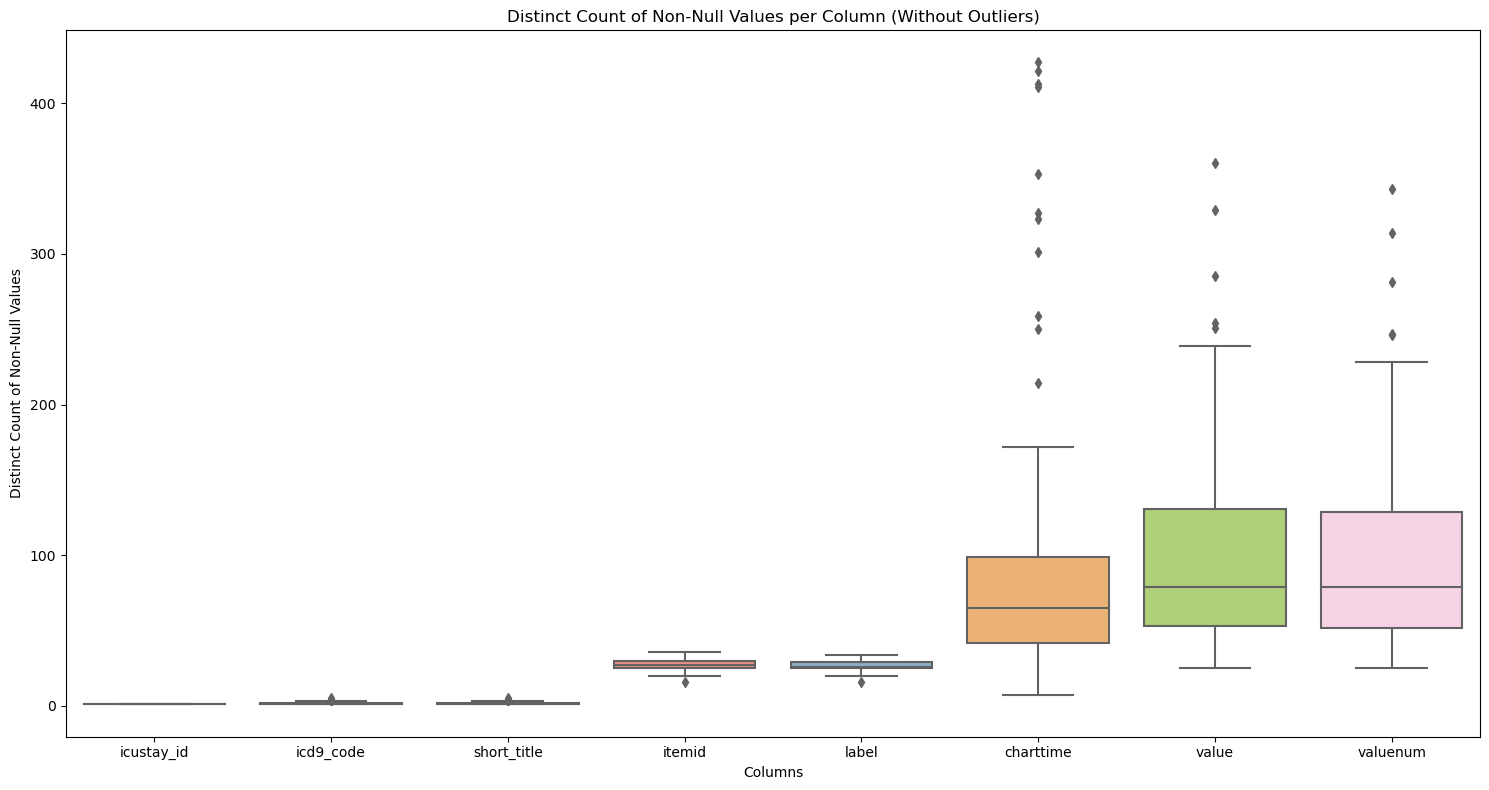

In [24]:
# Group by subject_id and hadm_id and count distinct non-null values for each column
counts = data.groupby(['subject_id', 'hadm_id']).agg(lambda x: x.nunique()).reset_index()

# Drop the 'subject_id' and 'hadm_id' columns to focus on the measurement counts
counts_data = counts.drop(columns=['subject_id', 'hadm_id'])

# Identify columns where the distinct count is greater than 2
relevant_columns = counts_data.columns[counts_data.max() > 2]

# Filter the counts_data to include only the relevant columns
counts_data_relevant = counts_data[relevant_columns]

# Calculate the mean and standard deviation for each relevant column
means = counts_data_relevant.mean()
stds = counts_data_relevant.std()

# Determine the threshold for removing outliers (2.5 standard deviations)
upper_threshold = means + 2.5 * stds
lower_threshold = means - 2.5 * stds

# Remove outliers
counts_data_no_outliers = counts_data_relevant[
    ((counts_data_relevant >= lower_threshold) & (counts_data_relevant <= upper_threshold)).all(axis=1)
]

# Set a beautiful palette
palette = sns.color_palette("Set3")

# Create a single box plot
plt.figure(figsize=(15, 8))
sns.boxplot(data=counts_data_no_outliers, palette=palette)
plt.title('Distinct Count of Non-Null Values per Column (Without Outliers)')
plt.xlabel('Columns')
plt.ylabel('Distinct Count of Non-Null Values')
plt.xticks(rotation=0, ha='center')
plt.grid(False)  # Remove grid lines

# Show the plot
plt.tight_layout()
plt.show()


<h2>Box Plot Analysis - Results</h2>
<p>As shown in the box plot, we have identified the columns with multiple measurements. We will research and select appropriate methods to represent these multiple measurements</p>


<h3> Displaying the data distribution of the label column </h3>

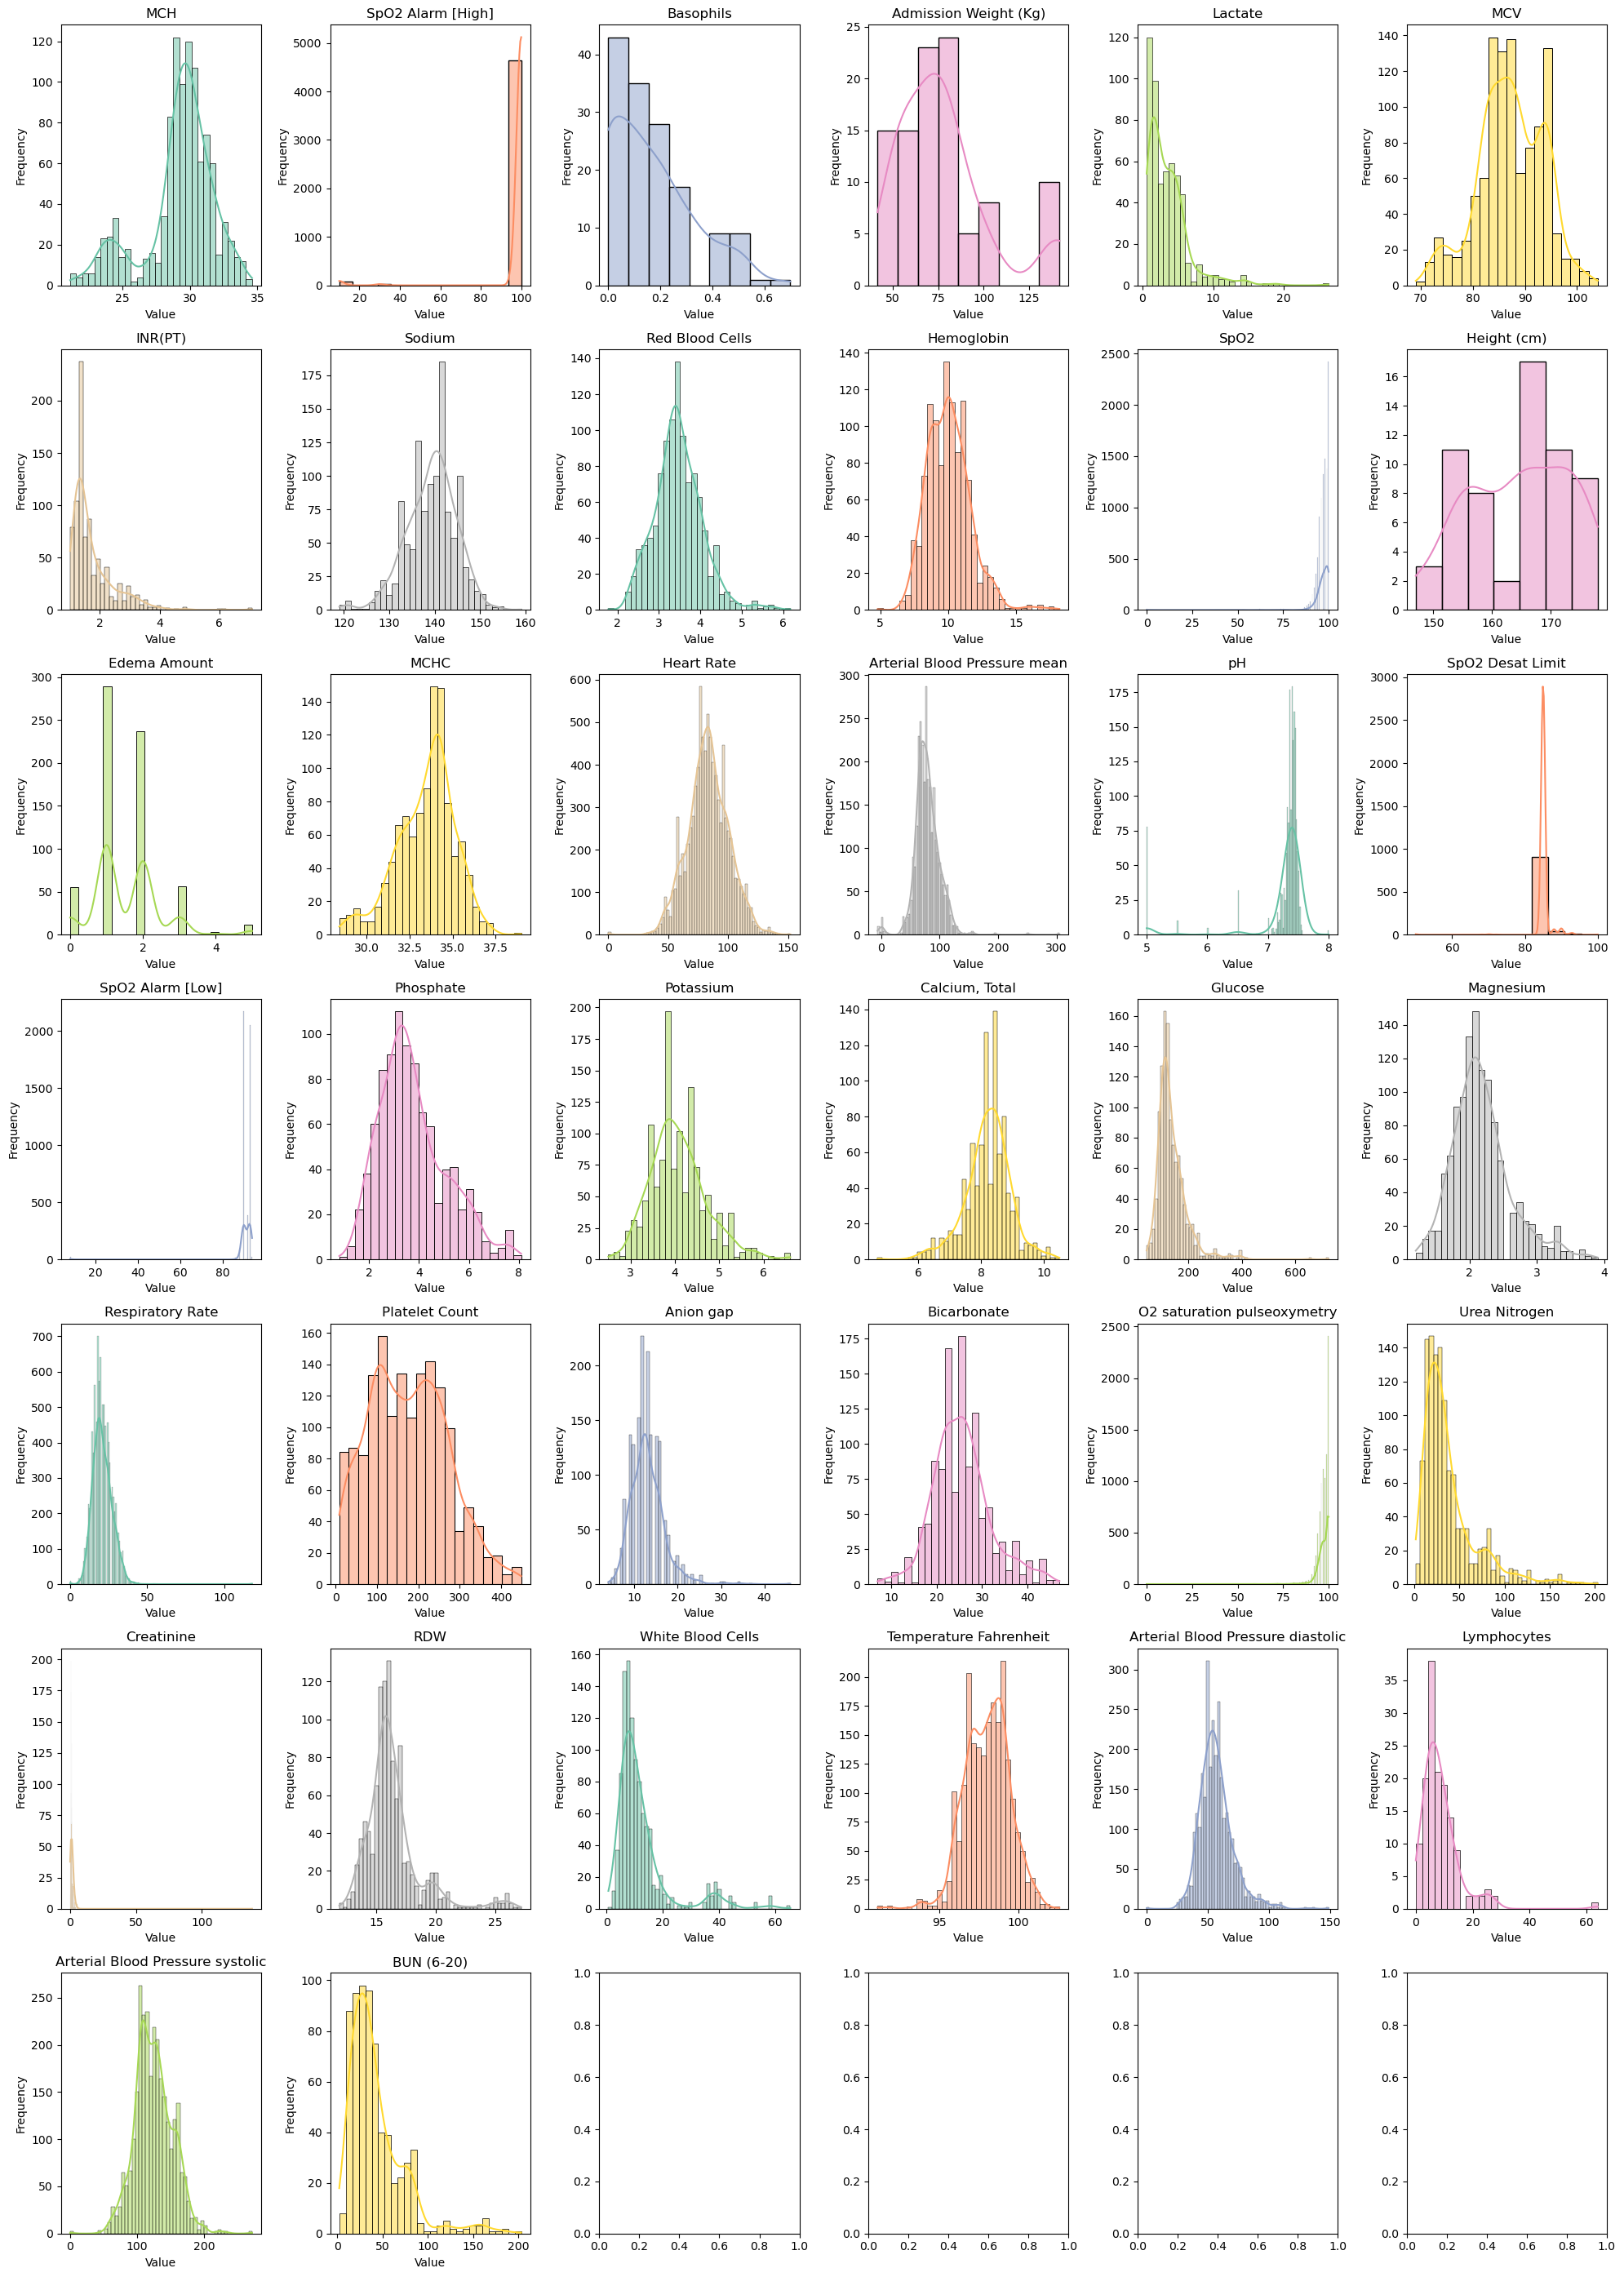

In [25]:
# List of all labels
labels = list(set(data["label"].to_list()))

# Use a color palette
palette = sns.color_palette("Set2", len(labels))

# Calculate the number of rows and columns for the subplot grid
num_plots = len(labels)
num_cols = 6  # Number of plots per row
num_rows = math.ceil(num_plots / num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot histograms for each label
for i, label in enumerate(labels):
    label_df = data[data['label'] == label]
    if not label_df.empty:
        sns.histplot(label_df['valuenum'], kde=True, color=palette[i % len(palette)], ax=axes[i])
        axes[i].set_title(f'{label}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(False)
    else:
        axes[i].axis('off')  # Hide the subplot if there's no data for this label

# Adjust layout
plt.tight_layout()
plt.show()


In [26]:
data.isna().sum()

subject_id                  0
num_of_hadm                 0
num_of_icustay              0
hadm_id                     0
icustay_id                  0
gender                      0
ethnicity                   0
age_group                   0
insurance                   0
icd9_code                   0
short_title                 0
diagnosis                   0
tot_adm_duration_in_days    0
tot_icu_duration_in_days    0
has_chartevents_data        0
itemid                      0
label                       0
charttime                   0
value                       0
valuenum                    0
died                        0
SpO2 Low flag               0
SpO2 High flag              0
SpO2 Desat Limit flag       0
dtype: int64

<h1>Selecting Appropriate Measures for Variables</h1>
<p>For variables with multiple measurements, we need to choose and apply a method to represent measurements at multiple time points. Below are the guidelines used to determine the most appropriate measure for each variable:</p>
<ul>
    <li><strong>Mean</strong>: Used if the distribution is normal, as indicated by statistical tests (e.g., p-value > 0.05 in the chi-square test).</li>
    <li><strong>Median</strong>: Used if the distribution is not normal, indicating skewed data or the presence of outliers.</li>
</ul>
<p>These guidelines help us aggregate the data correctly to focus on predicting heart failure during ICU stays.</p>


In [27]:
# Function to apply the selected measure to each group
def apply_measure(group, measure):
    if measure == 'mean':
        return group['valuenum'].mean()
    elif measure == 'median':
        return group['valuenum'].median()
    elif measure == 'max':
        return group['valuenum'].max()
    elif measure == 'mode':
        return group['valuenum'].mode()[0] if not group['valuenum'].mode().empty else np.nan
    elif measure == 'first':
        return group['valuenum'].iloc[0]
    elif measure == 'last':
        return group['valuenum'].iloc[-1]
    else:
        return np.nan

# Create an empty list to store the aggregated data
aggregated_data = []

# Group by subject_id and label
grouped = data.groupby(['subject_id', 'label'])

# Iterate through each group and apply the appropriate aggregation
for (subject_id, label), group in grouped:
    if label in summary_df.index:
        measure = summary_df.loc[label, 'selected_measure']
        aggregated_value = apply_measure(group, measure)
        row = group.iloc[0].copy()
        row['valuenum'] = aggregated_value
        aggregated_data.append(row)

# Convert the list of dictionaries to a DataFrame
data = pd.DataFrame(aggregated_data)

# Reset the index of the final DataFrame
data.reset_index(drop=True, inplace=True)


<h1>Pivoting and Aggregating Data</h1>
<p>This section transforms and aggregates the dataset:</p>
<ul>
    <li>Convert <code>icd9_code</code> to string format for pivoting.</li>
    <li>Pivot the table to create binary indicators for <code>icd9_code</code> based on the presence of values.</li>
    <li>Pivot the table to get the maximum value for each <code>label</code> (test result) per <code>subject_id</code>.</li>
    <li>Define aggregation functions for other columns, specifying how to combine values for each <code>subject_id</code>.</li>
    <li>Aggregate the data using the defined functions.</li>
    <li>Merge the pivot tables with the aggregated data.</li>
    <li>Fill NaN values with 0 for all columns.</li>
    <li>Ensure the <code>died</code> column is the last column in the dataset.</li>
</ul>
<p>This process creates a comprehensive and structured dataset for analysis.</p>


In [28]:
# List of ICD columns to fill missing values with 0
icds = ['39891', '4019', '40291', '41071', '41401',
        '4270', '4271', '42732', '4280', '42821', '42822', '42823', '42830',
        '42831', '42832', '42833', '42843', '43310']

# Convert icd9_code to string for pivot
data['icd9_code'] = data['icd9_code'].astype(str)

# Pivot tables based on subject_id
data_pivot_icd9 = data.pivot_table(index='subject_id', columns='icd9_code', values='valuenum', aggfunc=lambda x: 1 if x.count() > 0 else 0)
data_pivot_itemid = data.pivot_table(index='subject_id', columns='label', values='valuenum', aggfunc='max')

# Aggregate the remaining columns according to the specified methods
aggregation_functions = {
    'num_of_hadm': 'max',
    'num_of_icustay': 'max',
    'gender': lambda x: x.iloc[-1],
    'ethnicity': lambda x: x.iloc[-1],
    'age_group': lambda x: x.iloc[-1],
    'insurance': lambda x: x.iloc[-1],
    'tot_adm_duration_in_days': 'max',
    'tot_icu_duration_in_days': 'max',
    'died': 'max',
    'SpO2 Low flag': 'max',
    'SpO2 High flag': 'max',
    'SpO2 Desat Limit flag': 'max'
}

# Aggregate by subject_id
data_agg = data.groupby('subject_id').agg(aggregation_functions).reset_index()

# Merge the pivot tables with the aggregated data
final_agg = data_agg.merge(data_pivot_icd9.reset_index(), on='subject_id', how='left')
final_agg = final_agg.merge(data_pivot_itemid.reset_index(), on='subject_id', how='left')

# Fill missing values with 0 for specified ICD columns
final_agg[icds] = final_agg[icds].fillna(0)

# Ensure 'died' is the last column
columns = [col for col in final_agg.columns if col != 'died'] + ['died']
final_agg = final_agg[columns]

# Display the final dataframe
data = final_agg.copy()
data.head(2)


,subject_id,num_of_hadm,num_of_icustay,gender,ethnicity,age_group,insurance,tot_adm_duration_in_days,tot_icu_duration_in_days,SpO2 Low flag,...,Sodium,SpO2,SpO2 Alarm [High],SpO2 Alarm [Low],SpO2 Desat Limit,Temperature Fahrenheit,Urea Nitrogen,White Blood Cells,pH,died
0,10006,1,1,F,BLACK/AFRICAN AMERICAN,70-79,Medicare,8.8,1.6,1,...,138.5,98.368421,100.0,90.0,NaN,NaN,15.5,4.35,NaN,0
1,10013,1,1,F,UNKNOWN/NOT SPECIFIED,80-89,Medicare,2.7,2.6,0,...,137.0,91.000000,NaN,NaN,NaN,NaN,32.0,15.00,6.921667,1


In [29]:
columns_to_drop = ['SpO2 Alarm [High]', 'SpO2 Alarm [Low]', 'SpO2 Desat Limit']
data = data.drop(columns=columns_to_drop)

In [30]:
duplicates = data.duplicated()

# Count duplicate rows
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")



Number of duplicate rows: 0


In [32]:
#data.to_csv('final_data.csv')

<h2> Visualization </h2>

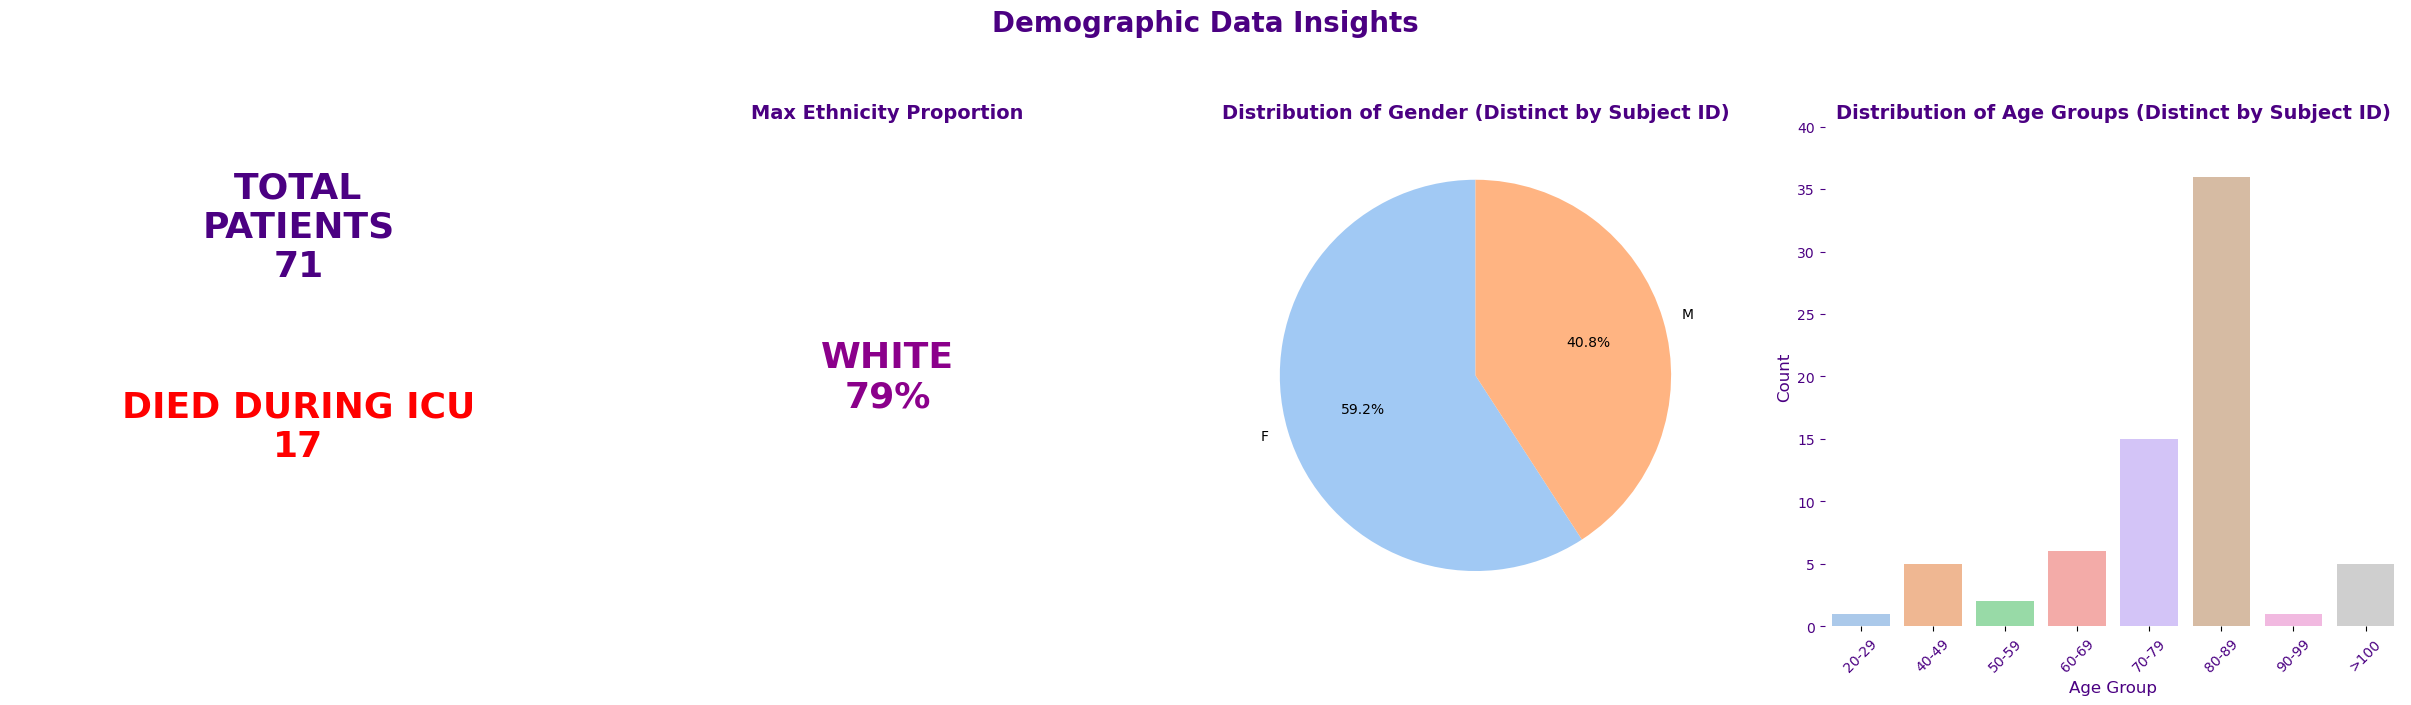

In [33]:
# Calculate distributions
gender_counts = data['gender'].value_counts()
ethnicity_counts = data['ethnicity'].value_counts()
max_ethnicity = ethnicity_counts.idxmax()
max_ethnicity_percentage = (ethnicity_counts.max() / ethnicity_counts.sum()) * 100

age_group_counts = data['age_group'].value_counts()
age_group_order = [age for age in ['<10', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '>100'] if age in age_group_counts.index]

# Total patients and patients who died
total_patients = data['subject_id'].nunique()
died_patients = data[data['died'] == 1]['subject_id'].nunique()

# Define a pastel color palette
palette = sns.color_palette("pastel")

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6), constrained_layout=True)
fig.patch.set_facecolor('white')
fig.suptitle('Demographic Data Insights', fontsize=20, fontweight='bold', color='#4B0082', y=1.15)

# Total patients and patients who died
axes[0].text(0.5, 0.8, f"TOTAL\nPATIENTS\n{total_patients}", fontsize=26, fontweight='bold', color='#4B0082', ha='center', va='center')
axes[0].text(0.5, 0.4, f"DIED DURING ICU\n{died_patients}", fontsize=26, fontweight='bold', color='red', ha='center', va='center')
axes[0].axis('off')
axes[0].set_facecolor('white')

# Max ethnicity proportion
axes[1].text(0.5, 0.5, f"{max_ethnicity}\n{max_ethnicity_percentage:.0f}%", fontsize=26, fontweight='bold', color='#8B008B', ha='center', va='center')
axes[1].set_title('Max Ethnicity Proportion', fontsize=14, fontweight='bold', color='#4B0082')
axes[1].axis('off')
axes[1].set_facecolor('white')

# Pie chart for gender distribution
axes[2].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=palette)
axes[2].set_title('Distribution of Gender (Distinct by Subject ID)', fontsize=14, fontweight='bold', color='#4B0082')
axes[2].axis('equal')
axes[2].set_facecolor('white')

# Bar chart for age group distribution
sns.countplot(data=data, x='age_group', order=age_group_order, palette=palette, ax=axes[3])
axes[3].set_title('Distribution of Age Groups (Distinct by Subject ID)', fontsize=14, fontweight='bold', color='#4B0082')
axes[3].set_xlabel('Age Group', fontsize=12, color='#4B0082')
axes[3].set_ylabel('Count', fontsize=12, color='#4B0082')
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45, fontsize=10, color='#4B0082')
axes[3].tick_params(axis='y', labelsize=10, colors='#4B0082')
axes[3].grid(False)

# Set y-ticks to whole numbers and adjust the scale
max_count = age_group_counts.max()
axes[3].set_yticks(np.arange(0, max_count + 5, 5))
axes[3].set_facecolor('white')

# Set face color for the axes
for ax in axes.flat:
    ax.set_facecolor('white')

# Add dividers for visual separation
for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Adjust layout to ensure proper spacing
plt.show()

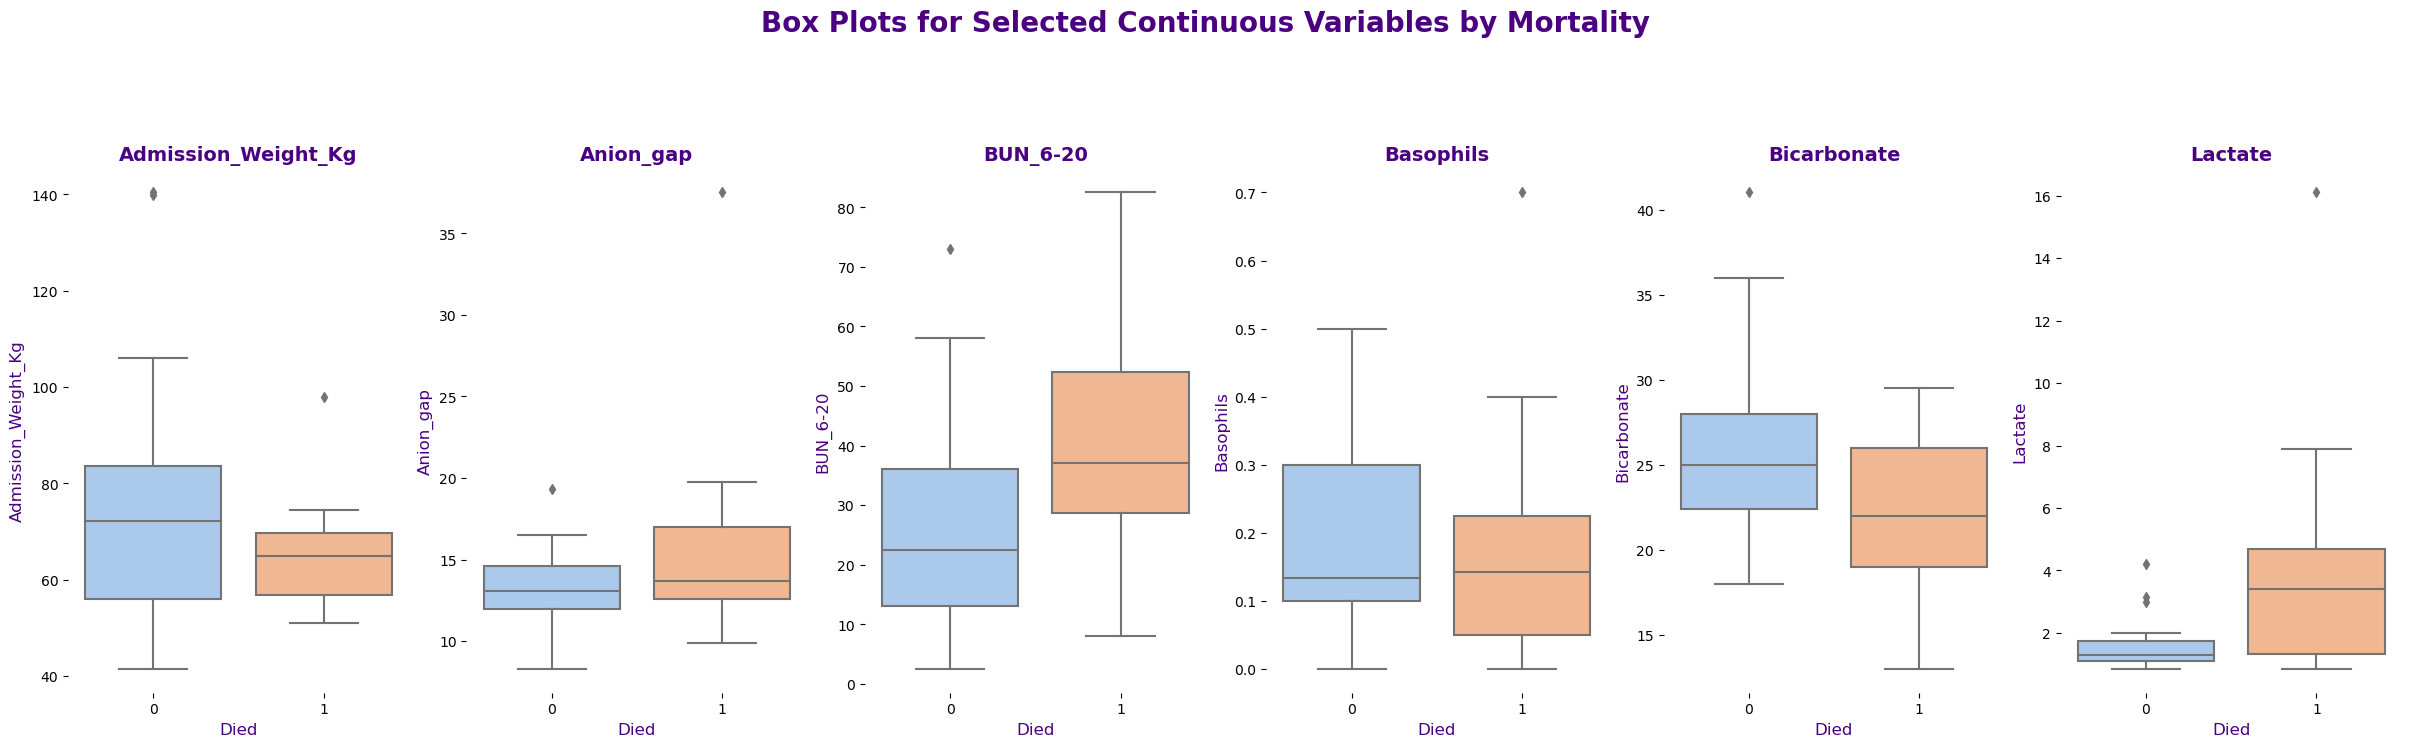

In [34]:


# Replace spaces and special characters in column names with underscores
data.columns = data.columns.str.replace(' ', '_').str.replace('[()]', '', regex=True)


# List of selected continuous variables
continuous_vars = ['Admission_Weight_Kg', 'Anion_gap', 'BUN_6-20', 'Basophils', 'Bicarbonate','Lactate']

# Define a pastel color palette
palette = sns.color_palette("pastel")

# Create subplots
fig, axes = plt.subplots(1, 6, figsize=(24, 6), constrained_layout=True)
fig.patch.set_facecolor('white')
fig.suptitle('Box Plots for Selected Continuous Variables by Mortality', fontsize=20, fontweight='bold', color='#4B0082', y=1.22)

# Create box plots
for i, var in enumerate(continuous_vars):  # Loop through the selected variables
    sns.boxplot(x='died', y=var, data=data, palette=palette, ax=axes[i])
    axes[i].set_title(f'{var}', fontsize=14, fontweight='bold', color='#4B0082')
    axes[i].set_xlabel('Died', fontsize=12, color='#4B0082')
    axes[i].set_ylabel(var, fontsize=12, color='#4B0082')

# Set face color for the axes
for ax in axes.flat:
    ax.set_facecolor('white')

# Add dividers for visual separation
for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.show()


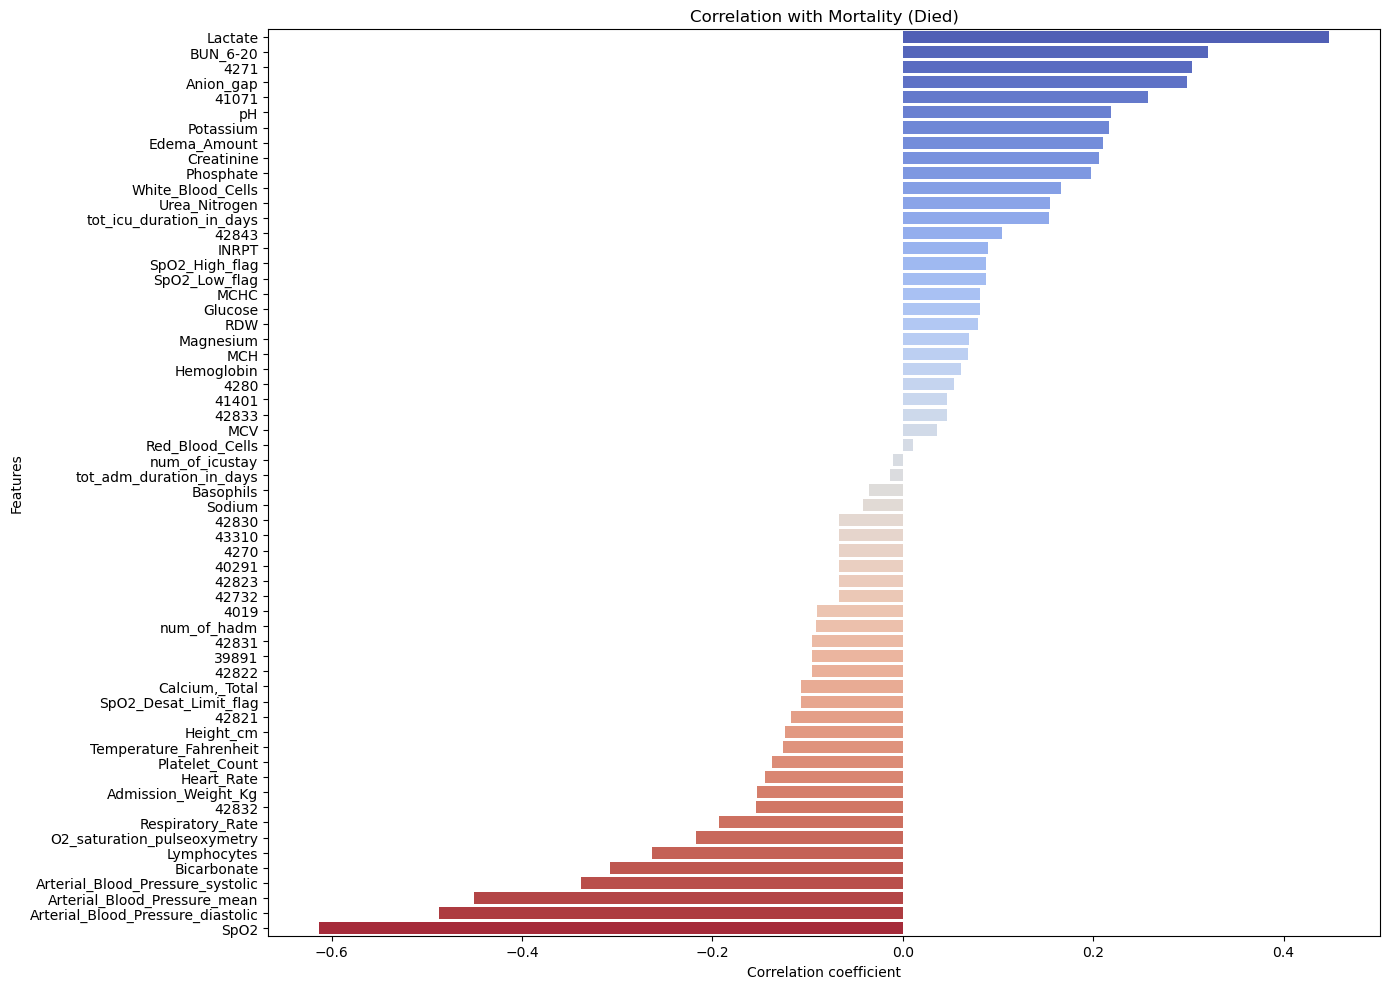

In [35]:
# Ensure columns of interest are numeric
numeric_columns = ['num_of_hadm', 'num_of_icustay', 'tot_adm_duration_in_days',
       'tot_icu_duration_in_days', 'SpO2_Low_flag', 'SpO2_High_flag',
       'SpO2_Desat_Limit_flag', '39891', '4019', '40291', '41071', '41401',
       '4270', '4271', '42732', '4280', '42821', '42822', '42823', '42830',
       '42831', '42832', '42833', '42843', '43310', 'Admission_Weight_Kg',
       'Anion_gap', 'Arterial_Blood_Pressure_diastolic',
       'Arterial_Blood_Pressure_mean', 'Arterial_Blood_Pressure_systolic',
       'BUN_6-20', 'Basophils', 'Bicarbonate', 'Calcium,_Total', 'Creatinine',
       'Edema_Amount', 'Glucose', 'Heart_Rate', 'Height_cm', 'Hemoglobin',
       'INRPT', 'Lactate', 'Lymphocytes', 'MCH', 'MCHC', 'MCV', 'Magnesium',
       'O2_saturation_pulseoxymetry', 'Phosphate', 'Platelet_Count',
       'Potassium', 'RDW', 'Red_Blood_Cells', 'Respiratory_Rate', 'Sodium',
       'SpO2','Temperature_Fahrenheit', 'Urea_Nitrogen', 'White_Blood_Cells', 'pH',
       'died']

# Filter the dataset for numeric columns
numeric_data = data[numeric_columns]

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Filter to get correlations with 'died' and exclude 'died' itself
correlation_with_died = correlation_matrix['died'].drop(labels=['died']).sort_values(ascending=False)

# Plot the filtered correlations
plt.figure(figsize=(14, 10))
sns.barplot(x=correlation_with_died.values, y=correlation_with_died.index, palette='coolwarm')
plt.title('Correlation with Mortality (Died)')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


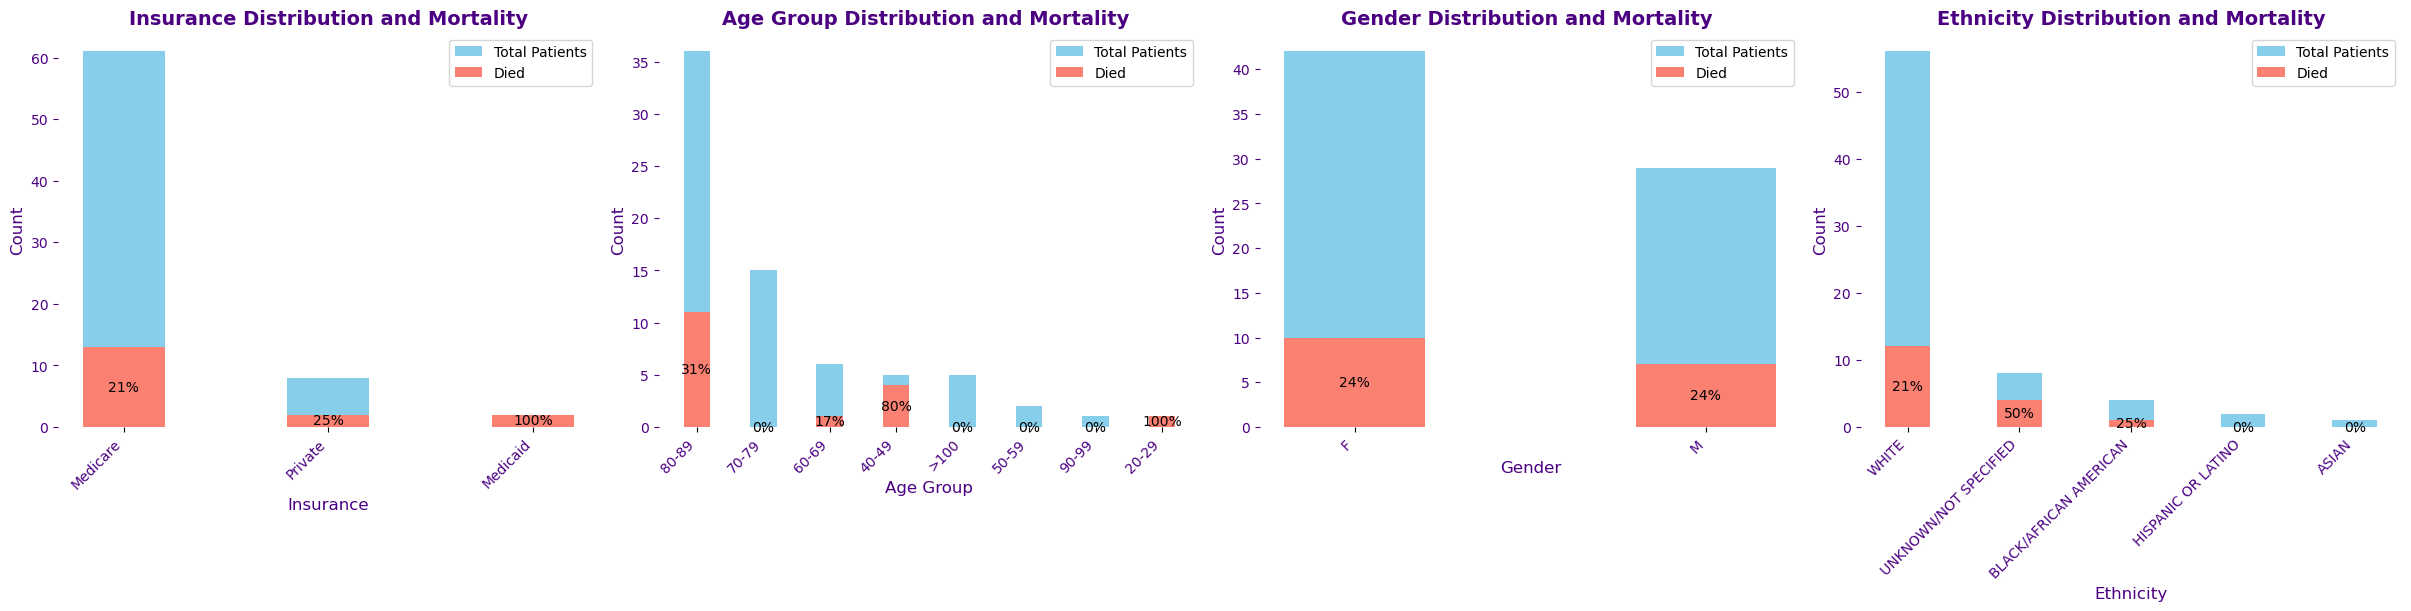

In [36]:
# Define a pastel color palette
palette = sns.color_palette("pastel")

# Calculate distributions for insurance, age group, gender, and ethnicity
insurance_counts = data['insurance'].value_counts()
insurance_died_counts = data[data['died'] == 1]['insurance'].value_counts()

age_group_counts = data['age_group'].value_counts()
age_group_died_counts = data[data['died'] == 1]['age_group'].value_counts()

gender_counts = data['gender'].value_counts()
gender_died_counts = data[data['died'] == 1]['gender'].value_counts()

ethnicity_counts = data['ethnicity'].value_counts()
ethnicity_died_counts = data[data['died'] == 1]['ethnicity'].value_counts()

# Create subplots with space between them
fig, axes = plt.subplots(1, 4, figsize=(24, 6), constrained_layout=True)
fig.patch.set_facecolor('white')

# Insurance stacked bar chart
bar_width = 0.4
insurance_labels = insurance_counts.index
insurance_total_counts = insurance_counts.values
insurance_died_counts = insurance_died_counts.reindex(insurance_labels, fill_value=0).values

# Plotting the bars
bar_positions = np.arange(len(insurance_labels))
axes[0].bar(bar_positions, insurance_total_counts, bar_width, label='Total Patients', color='skyblue')
axes[0].bar(bar_positions, insurance_died_counts, bar_width, label='Died', color='salmon')

# Add percentage labels
for i, (total, died) in enumerate(zip(insurance_total_counts, insurance_died_counts)):
    if total > 0:
        percentage = (died / total) * 100
        axes[0].text(i, died / 2, f'{percentage:.0f}%', ha='center', va='center', fontsize=10, color='black')

# Set plot details
axes[0].set_xticks(bar_positions)
axes[0].set_xticklabels(insurance_labels, rotation=45, ha='right', fontsize=10, color='#4B0082')
axes[0].set_title('Insurance Distribution and Mortality', fontsize=14, fontweight='bold', color='#4B0082')
axes[0].set_xlabel('Insurance', fontsize=12, color='#4B0082')
axes[0].set_ylabel('Count', fontsize=12, color='#4B0082')
axes[0].tick_params(axis='y', labelsize=10, colors='#4B0082')
axes[0].legend()

# Age group stacked bar chart
age_group_labels = age_group_counts.index
age_group_total_counts = age_group_counts.values
age_group_died_counts = age_group_died_counts.reindex(age_group_labels, fill_value=0).values

bar_positions = np.arange(len(age_group_labels))
axes[1].bar(bar_positions, age_group_total_counts, bar_width, label='Total Patients', color='skyblue')
axes[1].bar(bar_positions, age_group_died_counts, bar_width, label='Died', color='salmon')

# Add percentage labels
for i, (total, died) in enumerate(zip(age_group_total_counts, age_group_died_counts)):
    if total > 0:
        percentage = (died / total) * 100
        axes[1].text(i, died / 2, f'{percentage:.0f}%', ha='center', va='center', fontsize=10, color='black')

# Set plot details
axes[1].set_xticks(bar_positions)
axes[1].set_xticklabels(age_group_labels, rotation=45, ha='right', fontsize=10, color='#4B0082')
axes[1].set_title('Age Group Distribution and Mortality ', fontsize=14, fontweight='bold', color='#4B0082')
axes[1].set_xlabel('Age Group', fontsize=12, color='#4B0082')
axes[1].set_ylabel('Count', fontsize=12, color='#4B0082')
axes[1].tick_params(axis='y', labelsize=10, colors='#4B0082')
axes[1].legend()

# Gender stacked bar chart
gender_labels = gender_counts.index
gender_total_counts = gender_counts.values
gender_died_counts = gender_died_counts.reindex(gender_labels, fill_value=0).values

bar_positions = np.arange(len(gender_labels))
axes[2].bar(bar_positions, gender_total_counts, bar_width, label='Total Patients', color='skyblue')
axes[2].bar(bar_positions, gender_died_counts, bar_width, label='Died', color='salmon')

# Add percentage labels
for i, (total, died) in enumerate(zip(gender_total_counts, gender_died_counts)):
    if total > 0:
        percentage = (died / total) * 100
        axes[2].text(i, died / 2, f'{percentage:.0f}%', ha='center', va='center', fontsize=10, color='black')

# Set plot details
axes[2].set_xticks(bar_positions)
axes[2].set_xticklabels(gender_labels, rotation=45, ha='right', fontsize=10, color='#4B0082')
axes[2].set_title('Gender Distribution and Mortality ', fontsize=14, fontweight='bold', color='#4B0082')
axes[2].set_xlabel('Gender', fontsize=12, color='#4B0082')
axes[2].set_ylabel('Count', fontsize=12, color='#4B0082')
axes[2].tick_params(axis='y', labelsize=10, colors='#4B0082')
axes[2].legend()

# Ethnicity stacked bar chart
ethnicity_labels = ethnicity_counts.index
ethnicity_total_counts = ethnicity_counts.values
ethnicity_died_counts = ethnicity_died_counts.reindex(ethnicity_labels, fill_value=0).values

bar_positions = np.arange(len(ethnicity_labels))
axes[3].bar(bar_positions, ethnicity_total_counts, bar_width, label='Total Patients', color='skyblue')
axes[3].bar(bar_positions, ethnicity_died_counts, bar_width, label='Died', color='salmon')

# Add percentage labels
for i, (total, died) in enumerate(zip(ethnicity_total_counts, ethnicity_died_counts)):
    if total > 0:
        percentage = (died / total) * 100
        axes[3].text(i, died / 2, f'{percentage:.0f}%', ha='center', va='center', fontsize=10, color='black')

# Set plot details
axes[3].set_xticks(bar_positions)
axes[3].set_xticklabels(ethnicity_labels, rotation=45, ha='right', fontsize=10, color='#4B0082')
axes[3].set_title('Ethnicity Distribution and Mortality', fontsize=14, fontweight='bold', color='#4B0082')
axes[3].set_xlabel('Ethnicity', fontsize=12, color='#4B0082')
axes[3].set_ylabel('Count', fontsize=12, color='#4B0082')
axes[3].tick_params(axis='y', labelsize=10, colors='#4B0082')
axes[3].legend()

# Set face color for the axes
for ax in axes.flat:
    ax.set_facecolor('white')

# Add dividers for visual separation
for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.show()



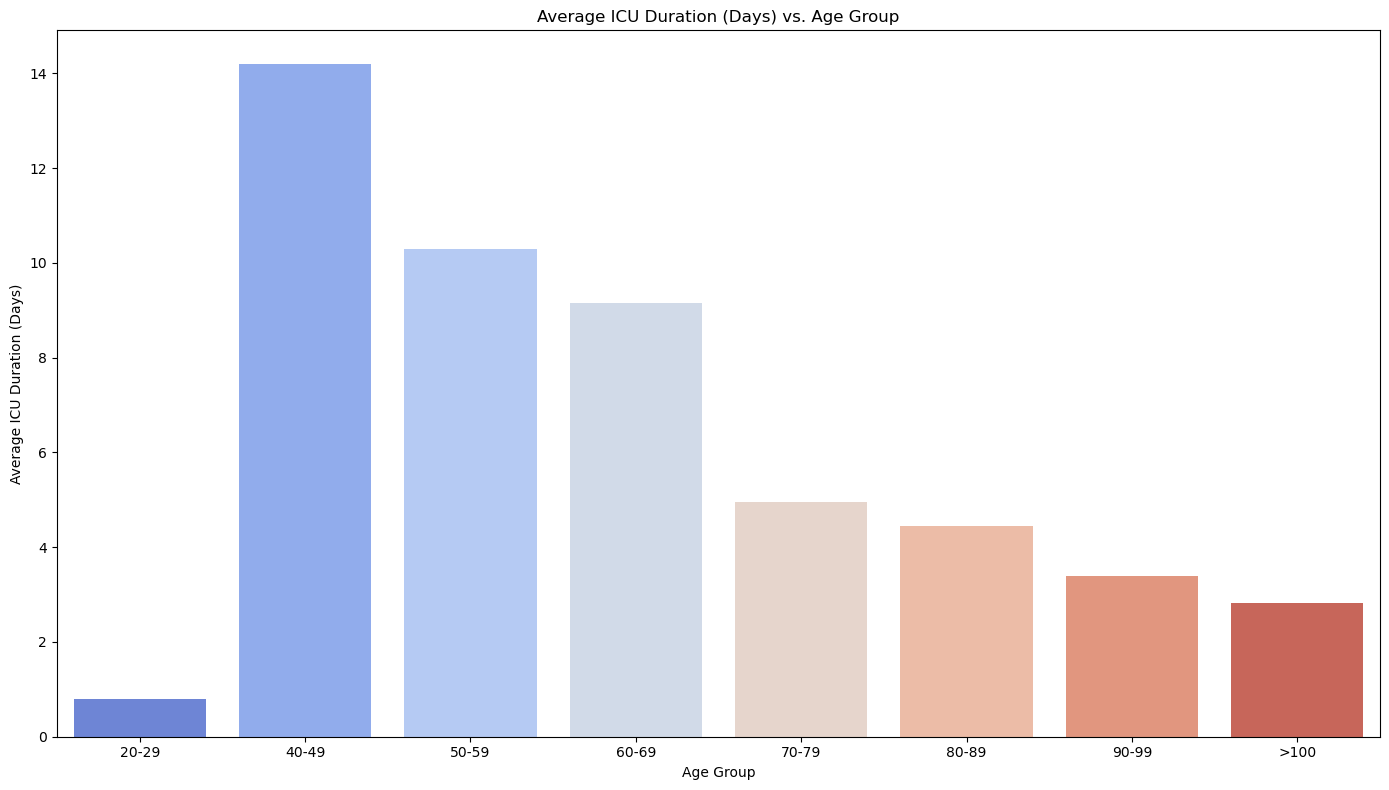

In [37]:

# Calculate the average ICU duration for each age group
average_icu_duration = data.groupby('age_group')['tot_icu_duration_in_days'].mean().reset_index()
average_icu_duration.columns = ['age_group', 'average_icu_duration']

plt.figure(figsize=(14, 8))
sns.barplot(data=average_icu_duration, x='age_group', y='average_icu_duration', palette='coolwarm')
plt.title('Average ICU Duration (Days) vs. Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average ICU Duration (Days)')
plt.tight_layout()
plt.show()


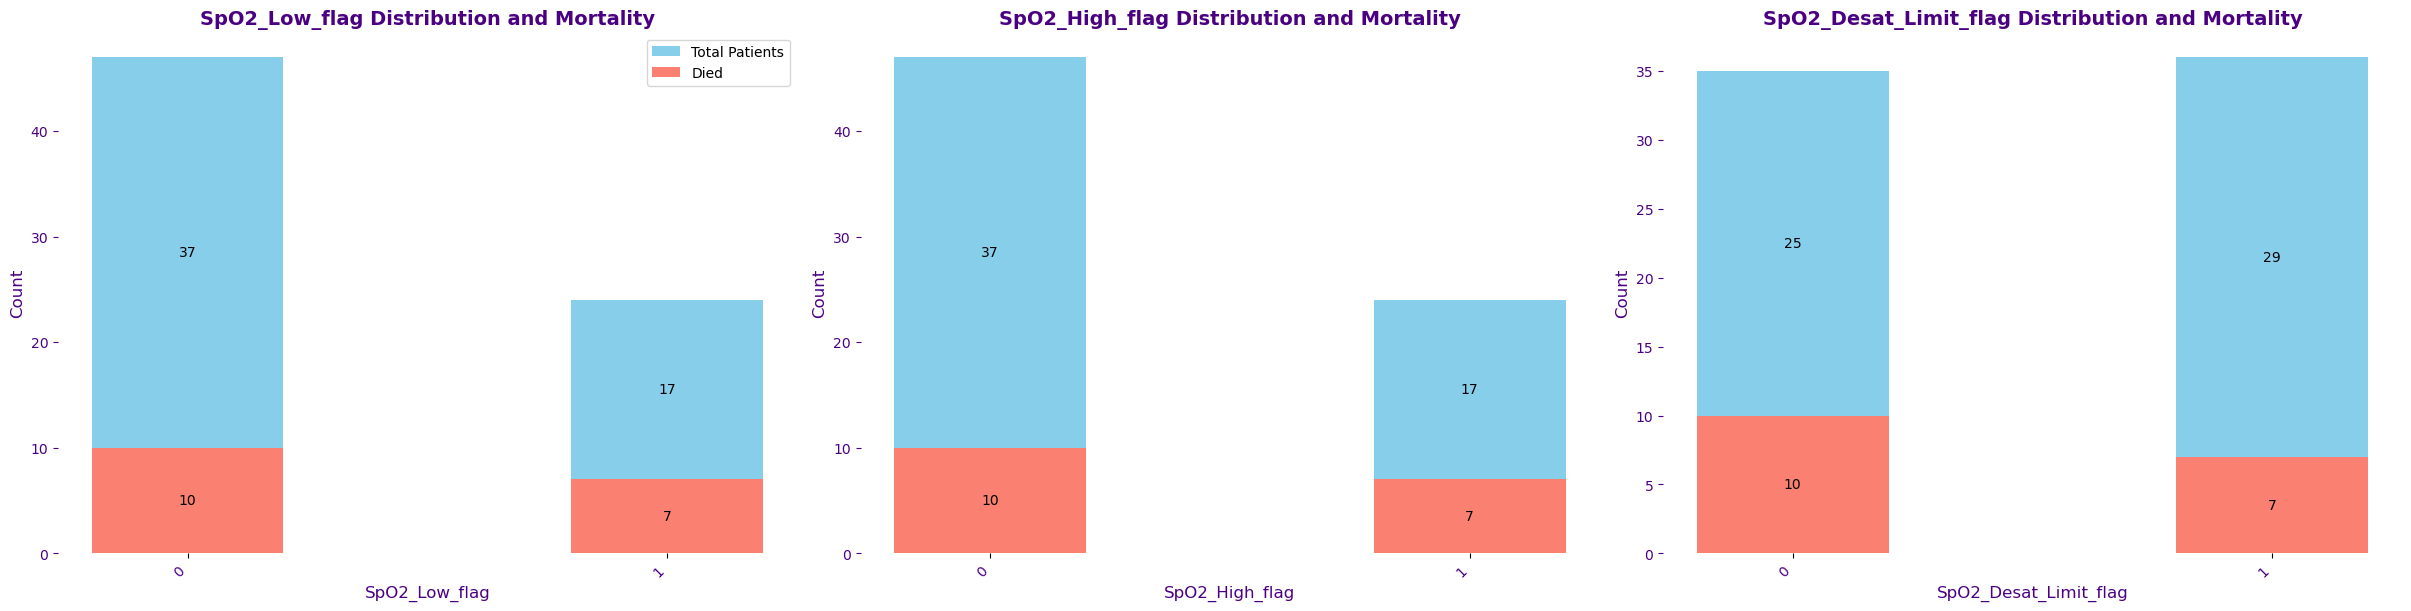

In [38]:
# Define a pastel color palette
palette = sns.color_palette("pastel")

# Define the flags
flags = ['SpO2_Low_flag', 'SpO2_High_flag', 'SpO2_Desat_Limit_flag']

# Initialize lists to store total counts and died counts
total_counts = []
died_counts = []

# Calculate total counts and died counts for each flag
for flag in flags:
    total = data[flag].value_counts().sort_index()
    died = data[data['died'] == 1][flag].value_counts().sort_index()
    
    # Ensure the counts for both 0 and 1 are included
    total_counts.append(total.reindex([0, 1], fill_value=0))
    died_counts.append(died.reindex([0, 1], fill_value=0))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6), constrained_layout=True)
fig.patch.set_facecolor('white')

# Define bar width
bar_width = 0.4

# Plot the bars
for i, flag in enumerate(flags):
    total = total_counts[i].values
    died = died_counts[i].values
    survived = total - died

    bar_positions = np.arange(len(total))
    
    # Plot total bars in the background (visible part will be survivors)
    axes[i].bar(bar_positions, total, bar_width, color='skyblue', label='Total Patients')
    
    # Plot died bars in the foreground
    axes[i].bar(bar_positions, died, bar_width, color='salmon', label='Died')

    # Add count labels
    for j in range(len(total)):
        if total[j] > 0:
            died_count = died[j]
            survived_count = survived[j]
            axes[i].text(j, died[j] / 2, f'{died_count}', ha='center', va='center', fontsize=10, color='black')
            axes[i].text(j, total[j] - (total[j] - died[j]) / 2, f'{survived_count}', ha='center', va='center', fontsize=10, color='black')

    # Set plot details
    axes[i].set_xticks(bar_positions)
    axes[i].set_xticklabels(['0', '1'], rotation=45, ha='right', fontsize=10, color='#4B0082')
    axes[i].set_title(f'{flag} Distribution and Mortality', fontsize=14, fontweight='bold', color='#4B0082')
    axes[i].set_xlabel(flag, fontsize=12, color='#4B0082')
    axes[i].set_ylabel('Count', fontsize=12, color='#4B0082')
    axes[i].tick_params(axis='y', labelsize=10, colors='#4B0082')
    if i == 0:
        axes[i].legend()

# Set face color for the axes
for ax in axes.flat:
    ax.set_facecolor('white')

# Add dividers for visual separation
for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.show()


<h2> Statistical Tests </h2>

Running T-test for total icu duration in days with our result variable 

<h1>Independent T-Test for ICU Duration</h1>
<p>This section performs an independent t-test to compare ICU duration between patients who died and those who survived:</p>
<ul>
    <li>Split the data into two groups based on the <code>died</code> column:
        <ul>
            <li><code>died_icu_duration</code>: ICU duration for patients who died.</li>
            <li><code>survived_icu_duration</code>: ICU duration for patients who survived.</li>
        </ul>
    </li>
    <li>Define the hypotheses:
        <ul>
            <li>Null Hypothesis (H0): There is no significant difference in ICU duration between those who died and those who survived.</li>
            <li>Alternative Hypothesis (H1): There is a significant difference in ICU duration between those who died and those who survived.</li>
        </ul>
    </li>
    <li>Perform an independent t-test to compare the ICU durations of the two groups.</li>
    <li>Output the t-statistic and p-value to determine the significance of the results.</li>
</ul>
<p>Based on the P-value, we cannot reject the null hypothesis (H0). Therefore, there isn't a significant difference between the ICU duration and the mortality (died) columns.</p>


In [39]:
import scipy.stats as stats

# Split the data into two groups
died_icu_duration = data[data['died'] == 1]['tot_icu_duration_in_days']
survived_icu_duration = data[data['died'] == 0]['tot_icu_duration_in_days']

#Null Hypothesis (H0): There is no significant difference in ICU duration (tot_icu_duration_in_days) between those who died and those who survived.
#Alternative Hypothesis (H1): There is a significant difference in ICU duration (tot_icu_duration_in_days) between those who died and those who survived.

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(died_icu_duration, survived_icu_duration, nan_policy='omit')

print(f'T-test for ICU Duration (tot_icu_duration_in_days):')
print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_value:.4f}')


T-test for ICU Duration (tot_icu_duration_in_days):
T-statistic: 1.2893
P-value: 0.2016


<h1>Independent T-Test for Anion Gap Levels</h1>
<p>This section performs an independent t-test to compare Anion gap levels between patients who died and those who survived:</p>
<ul>
    <li>Split the data into two groups based on the <code>died</code> column:
        <ul>
            <li><code>died_anion_gap</code>: Anion gap levels for patients who died.</li>
            <li><code>survived_anion_gap</code>: Anion gap levels for patients who survived.</li>
        </ul>
    </li>
    <li>Define the hypotheses:
        <ul>
            <li>Null Hypothesis (H0): There is no significant difference in Anion gap levels between those who died and those who survived.</li>
            <li>Alternative Hypothesis (H1): There is a significant difference in Anion gap levels between those who died and those who survived.</li>
        </ul>
    </li>
    <li>Perform an independent t-test to compare the Anion gap levels of the two groups.</li>
    <li>Output the t-statistic and p-value to determine the significance of the results.</li>
</ul>
<p>Based on the P-value, we reject the null hypothesis (H0). Therefore, there is a significant difference between Anion gap levels and the mortality (died) columns.</p>


In [40]:
# Split the data into two groups
died_anion_gap = data[data['died'] == 1]['Anion_gap']
survived_anion_gap = data[data['died'] == 0]['Anion_gap']

#Null Hypothesis (H0): There is no significant difference in anion gap levels between those who died and those who survived.
#Alternative Hypothesis (H1): There is a significant difference in anion gap levels between those who died and those who survived.

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(died_anion_gap, survived_anion_gap, nan_policy='omit')

print(f'T-test for Anion Gap levels:')
print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_value:.4f}')


T-test for Anion Gap levels:
T-statistic: 2.5646
P-value: 0.0126


<h1>Independent T-Test for Lactate Levels</h1>
<p>This section performs an independent t-test to compare Lactate levels between patients who died and those who survived:</p>
<ul>
    <li>Split the data into two groups based on the <code>died</code> column:
        <ul>
            <li><code>died_Lactate</code>: Lactate levels for patients who died.</li>
            <li><code>survived_Lactate</code>: Lactate levels for patients who survived.</li>
        </ul>
    </li>
    <li>Define the hypotheses:
        <ul>
            <li>Null Hypothesis (H0): There is no significant difference in Lactate levels between those who died and those who survived.</li>
            <li>Alternative Hypothesis (H1): There is a significant difference in Lactate levels between those who died and those who survived.</li>
        </ul>
    </li>
    <li>Perform an independent t-test to compare the Lactate levels of the two groups.</li>
    <li>Output the t-statistic and p-value to determine the significance of the results.</li>
</ul>
<p>Based on the P-value, we reject the null hypothesis (H0). Therefore, there is a significant difference between Lactate levels and the mortality (died) columns.</p>


In [41]:
# Split the data into two groups
died_Lactate = data[data['died'] == 1]['Lactate']
survived_Lactate = data[data['died'] == 0]['Lactate']

#Null Hypothesis (H0): There is no significant difference in Lactate levels between those who died and those who survived.
#Alternative Hypothesis (H1): There is a significant difference in Lactate levels between those who died and those who survived.

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(died_Lactate, survived_Lactate, nan_policy='omit')

print(f'T-test for Lactate:')
print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_value:.4f}')


T-test for Lactate:
T-statistic: 3.0074
P-value: 0.0048


<h1>Independent T-Test for SpO2 Levels</h1>
<p>This section performs an independent t-test to compare SpO2 levels between patients who died and those who survived:</p>
<ul>
    <li>Split the data into two groups based on the <code>died</code> column:
        <ul>
            <li><code>died_SpO2</code>: SpO2 levels for patients who died.</li>
            <li><code>survived_SpO2</code>: SpO2 levels for patients who survived.</li>
        </ul>
    </li>
    <li>Define the hypotheses:
        <ul>
            <li>Null Hypothesis (H0): There is no significant difference in SpO2 levels between those who died and those who survived.</li>
            <li>Alternative Hypothesis (H1): There is a significant difference in SpO2 levels between those who died and those who survived.</li>
        </ul>
    </li>
    <li>Perform an independent t-test to compare the SpO2 levels of the two groups.</li>
    <li>Output the t-statistic and p-value to determine the significance of the results.</li>
</ul>
<p>Based on the P-value, we reject the null hypothesis (H0). Therefore, there is a significant difference between SpO2 levels and the mortality (died) columns.</p>


In [42]:
# Split the data into two groups
died_SpO2 = data[data['died'] == 1]['SpO2']
survived_SpO2 = data[data['died'] == 0]['SpO2']

#Null Hypothesis (H0): There is no significant difference in SpO2 between those who died and those who survived.
#Alternative Hypothesis (H1): There is a significant difference in SpO2 between those who died and those who survived.

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(died_SpO2, survived_SpO2, nan_policy='omit')

print(f'T-test for SpO2:')
print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_value:.4f}')

T-test for SpO2:
T-statistic: -4.4629
P-value: 0.0001
